# build and test a RAG pipeline with GPT-4o-mini

### This notebook builds a working RAG pipeline using gpt-4o-mini as the answerer. Then it finishes off by training a Random Forest and an ensemble. It’s the practical part — test RAG, then actually combine models

In [4]:
# imports

import os
import re
import math
import json
from tqdm import tqdm
import random
from dotenv import load_dotenv
from huggingface_hub import login
import matplotlib.pyplot as plt
import numpy as np
import pickle
from openai import OpenAI
from sentence_transformers import SentenceTransformer
from datasets import load_dataset
import chromadb
from testing import Tester

In [5]:
# environment

load_dotenv(override=True)
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN', 'your-key-if-not-using-env')

In [6]:
# Log in to HuggingFace

hf_token = os.environ['HF_TOKEN']
login(hf_token, add_to_git_credential=True)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [7]:
# Another import after Logging in to Hugging Face - thank you Trung N.!

from items import Item

In [ ]:
# create OpenAI client using OPENAI_API_KEY from env
openai = OpenAI()

In [ ]:
# Load in the test pickle file


with open('test.pkl', 'rb') as file:
    test = pickle.load(file)

In [ ]:
# Builds a text block listing similar items + their prices that we’ll pass as context to the LLM
def make_context(similars, prices):
    message = "To provide some context, here are some other items that might be similar to the item you need to estimate.\n\n"
    for similar, price in zip(similars, prices):
        message += f"Potentially related product:\n{similar}\nPrice is ${price:.2f}\n\n"
    return message

In [ ]:
# This composes the chat message list (system + user + assistant placeholder) for the LLM, it tells the model to reply only with a price
def messages_for(item, similars, prices):
    system_message = "You estimate prices of items. Reply only with the price, no explanation"
    user_prompt = make_context(similars, prices)
    user_prompt += "And now the question for you:\n\n"
    user_prompt += item.test_prompt().replace(" to the nearest dollar","").replace("\n\nPrice is $","")
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt},
        {"role": "assistant", "content": "Price is $"}
    ]

In [ ]:
# Open the Chroma DB and get the products collection to query similar items from the vectorstore
DB = "products_vectorstore"

In [13]:
client = chromadb.PersistentClient(path=DB)
collection = client.get_or_create_collection('products')

In [ ]:
# Same cleaning function as before — strip question wrapper from item prompt so we embed only the product text
def description(item):
    text = item.prompt.replace("How much does this cost to the nearest dollar?\n\n", "")
    return text.split("\n\nPrice is $")[0]

In [ ]:
# Quick check to see the cleaned text of first test item
description(test[0])

"OEM AC Compressor w/A/C Repair Kit For Ford F150 F-150 V8 & Lincoln Mark LT 2007 2008 - BuyAutoParts NEW\nAs one of the world's largest automotive parts suppliers, our parts are trusted every day by mechanics and vehicle owners worldwide. This A/C Compressor and Components Kit is manufactured and tested to the strictest OE standards for unparalleled performance. Built for trouble-free ownership and 100% visually inspected and quality tested, this A/C Compressor and Components Kit is backed by our 100% satisfaction guarantee. Guaranteed Exact Fit for easy installation 100% BRAND NEW, premium ISO/TS 16949 quality - tested to meet or exceed OEM specifications Engineered for superior durability, backed by industry-leading unlimited-mileage warranty Included in this K"

In [ ]:
# Load all-MiniLM to compute embeddings used in query should be fast locally
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

In [ ]:
# Encode an item into a vector for querying Chroma
def vector(item):
    return model.encode([description(item)])

In [ ]:
# Query Chroma with the item embedding and return the top 5 similar documents and their prices
def find_similars(item):
    results = collection.query(query_embeddings=vector(item).astype(float).tolist(), n_results=5)
    documents = results['documents'][0][:]
    prices = [m['price'] for m in results['metadatas'][0][:]]
    return documents, prices

In [ ]:
# Print the raw text of test[1] prompt to see full original prompt
print(test[1].prompt)

How much does this cost to the nearest dollar?

Motorcraft YB3125 Fan Clutch
Motorcraft YB3125 Fan Clutch Package Dimensions 25.146 cms (L) x 20.066 cms (W) x 15.494 cms (H) Package Quantity 1 Product Type Auto Part Country Of Origin China Manufacturer Motorcraft, Brand Motorcraft, Model Fan Clutch, Weight 5 pounds, Dimensions 10 x 7.63 x 6.25 inches, Country of Origin China, model number Exterior Painted, Manufacturer Part Rank Automotive Automotive Replacement Engine Fan Clutches 583, Domestic Shipping can be shipped within U.S., International Shipping This item can be shipped to select countries outside of the U.S. Learn More, Available October 10, 2007

Price is $225.00


In [ ]:
# Run find_similars to fetch documents and prices for the example item
documents, prices = find_similars(test[1])

In [ ]:
# Show the context text passed to the LLM
print(make_context(documents, prices))

To provide some context, here are some other items that might be similar to the item you need to estimate.

Potentially related product:
Four Seasons 75721 Fan Motor
Fan Motor Meets or exceeds OE design and performance Part number 75721 Fit type Vehicle Specific Package Dimensions 12.953 H x 16.002 L x 15.748 W (centimeters) Manufacturer Four Seasons, Brand Four Seasons, Model Weight 2.18 pounds, Dimensions 6.3 x 6.3 x 6.4 inches, Country of Origin Canada, model number 75721, Is Discontinued No, Exterior Machined, Manufacturer Part 75721, Rank Tools & Home Improvement Electric Fan Motors 1535, Domestic Shipping can be shipped within U.S., International Shipping This item can be shipped to select countries outside of the U.S. Learn More, Available October 10, 2007
Price is $73.54

Potentially related product:
Motorcraft MM1097 Fan and Motor Assembly
Premium aftermarket replacement parts for Ford and Lincoln vehicles, Tested to provide performance and long-life reliability. labor include

In [ ]:
# Print the final messages structure that will be sent to the chat API
print(messages_for(test[1], documents, prices))

[{'role': 'system', 'content': 'You estimate prices of items. Reply only with the price, no explanation'}, {'role': 'user', 'content': 'To provide some context, here are some other items that might be similar to the item you need to estimate.\n\nPotentially related product:\nFour Seasons 75721 Fan Motor\nFan Motor Meets or exceeds OE design and performance Part number 75721 Fit type Vehicle Specific Package Dimensions 12.953 H x 16.002 L x 15.748 W (centimeters) Manufacturer Four Seasons, Brand Four Seasons, Model Weight 2.18 pounds, Dimensions 6.3 x 6.3 x 6.4 inches, Country of Origin Canada, model number 75721, Is Discontinued No, Exterior Machined, Manufacturer Part 75721, Rank Tools & Home Improvement Electric Fan Motors 1535, Domestic Shipping can be shipped within U.S., International Shipping This item can be shipped to select countries outside of the U.S. Learn More, Available October 10, 2007\nPrice is $73.54\n\nPotentially related product:\nMotorcraft MM1097 Fan and Motor Asse

In [ ]:
# Parse a string like $99.99 into a float. Handy because model answers may include text or a symbol
def get_price(s):
    s = s.replace('$','').replace(',','')
    match = re.search(r"[-+]?\d*\.\d+|\d+", s)
    return float(match.group()) if match else 0

In [ ]:
# Quick example showing the parser works
get_price("The price for this is $99.99")

99.99

In [ ]:
# This is the main RAG function: it finds similars, composes the messages, calls gpt-4o-mini, then parses the reply to a number. The max_tokens=5 keeps replies short
# The function for gpt-4o-mini

def gpt_4o_mini_rag(item):
    documents, prices = find_similars(item)
    response = openai.chat.completions.create(
        model="gpt-4o-mini", 
        messages=messages_for(item, documents, prices),
        seed=42,
        max_tokens=5
    )
    reply = response.choices[0].message.content
    return get_price(reply)

In [ ]:
# Run the RAG pricer for one test item to see the output
gpt_4o_mini_rag(test[1])

59.95

In [ ]:
# Show the actual price for test[1] so you can compare prediction vs reality
test[1].price

225.11

1: Guess: $295.41 Truth: $374.41 Error: $79.00 SLE: 0.06 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $59.95 Truth: $225.11 Error: $165.16 SLE: 1.72 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $47.75 Truth: $61.68 Error: $13.93 SLE: 0.06 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $399.99 Truth: $599.99 Error: $200.00 SLE: 0.16 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $18.99 Truth: $16.99 Error: $2.00 SLE: 0.01 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $12.99 Truth: $31.99 Error: $19.00 SLE: 0.74 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $99.99 Truth: $101.79 Error: $1.80 SLE: 0.00 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $239.00 Truth: $289.00 Error: $50.00 SLE: 0.04 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $489.99 Truth: $635.86 Error: $145.87 SLE: 0.07 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $79.99 Truth: $65.99 Error: $14.00 SLE: 0.04 Ite

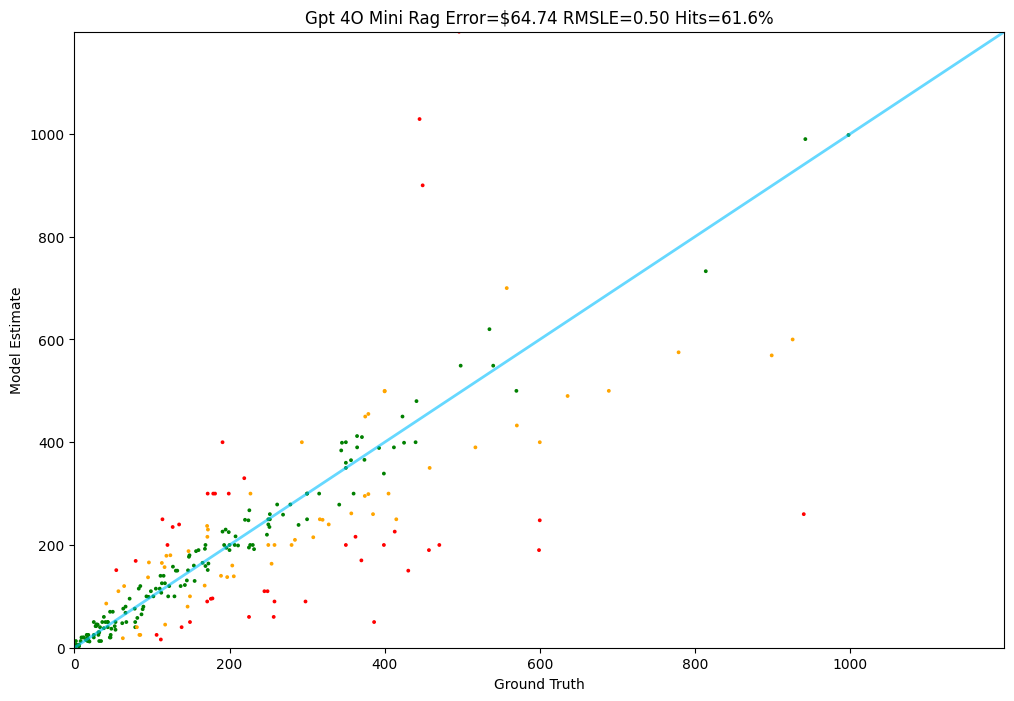

In [ ]:
# Use local Tester to evaluate model on the whole test set (this runs multiple items and prints aggregate metrics or prints per-item results)
Tester.test(gpt_4o_mini_rag, test)



### Finishing off with Random Forests & Ensemble

In [31]:
# imports

import os
import re
import math
import json
from tqdm import tqdm
import random
from dotenv import load_dotenv
from huggingface_hub import login
import numpy as np
import pickle
from openai import OpenAI
from sentence_transformers import SentenceTransformer
from datasets import load_dataset
import chromadb
from items import Item
from testing import Tester
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import joblib


In [32]:
# CONSTANTS

QUESTION = "How much does this cost to the nearest dollar?\n\n"
DB = "products_vectorstore"

In [33]:
# environment

load_dotenv(override=True)
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN', 'your-key-if-not-using-env')

In [34]:
# Log in to HuggingFace

hf_token = os.environ['HF_TOKEN']
login(hf_token, add_to_git_credential=True)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [35]:
# Another import after Logging in to Hugging Face - thank you Trung N.!

from items import Item

In [36]:
# Load in the test pickle file:

with open('test.pkl', 'rb') as file:
    test = pickle.load(file)

In [37]:
client = chromadb.PersistentClient(path=DB)
collection = client.get_or_create_collection('products')

In [38]:
result = collection.get(include=['embeddings', 'documents', 'metadatas'])
vectors = np.array(result['embeddings'])
documents = result['documents']
prices = [metadata['price'] for metadata in result['metadatas']]

# Random Forest
We will now train a Random Forest model.


this time we'll use the vectors we already have in Chroma, from the SentenceTransformer model.

In [ ]:


rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(vectors, prices)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [40]:
# Save the model to a file

joblib.dump(rf_model, 'random_forest_model.pkl')

['random_forest_model.pkl']

In [41]:
# Load it back in again

rf_model = joblib.load('random_forest_model.pkl')

In [ ]:
# Import your agents (specialist, frontier, random forest wrapper) and instantiate them so we can compare different pricers
from agents.specialist_agent import SpecialistAgent
from agents.frontier_agent import FrontierAgent
from agents.random_forest_agent import RandomForestAgent

In [43]:
specialist = SpecialistAgent()
frontier = FrontierAgent(collection)
random_forest = RandomForestAgent()

In [ ]:
# Define a brief description() and an adapter function rf calling the RF agent
def description(item):
    return item.prompt.split("to the nearest dollar?\n\n")[1].split("\n\nPrice is $")[0]

In [45]:
def rf(item):
    return random_forest.price(description(item))

1: Guess: $267.36 Truth: $374.41 Error: $107.05 SLE: 0.11 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $200.57 Truth: $225.11 Error: $24.54 SLE: 0.01 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $211.23 Truth: $61.68 Error: $149.55 SLE: 1.49 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $354.88 Truth: $599.99 Error: $245.11 SLE: 0.27 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $191.08 Truth: $16.99 Error: $174.09 SLE: 5.61 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $83.72 Truth: $31.99 Error: $51.73 SLE: 0.89 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $317.68 Truth: $101.79 Error: $215.89 SLE: 1.28 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $236.16 Truth: $289.00 Error: $52.84 SLE: 0.04 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $348.16 Truth: $635.86 Error: $287.70 SLE: 0.36 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $225.76 Truth: $65.99 Error: $159.77 SL

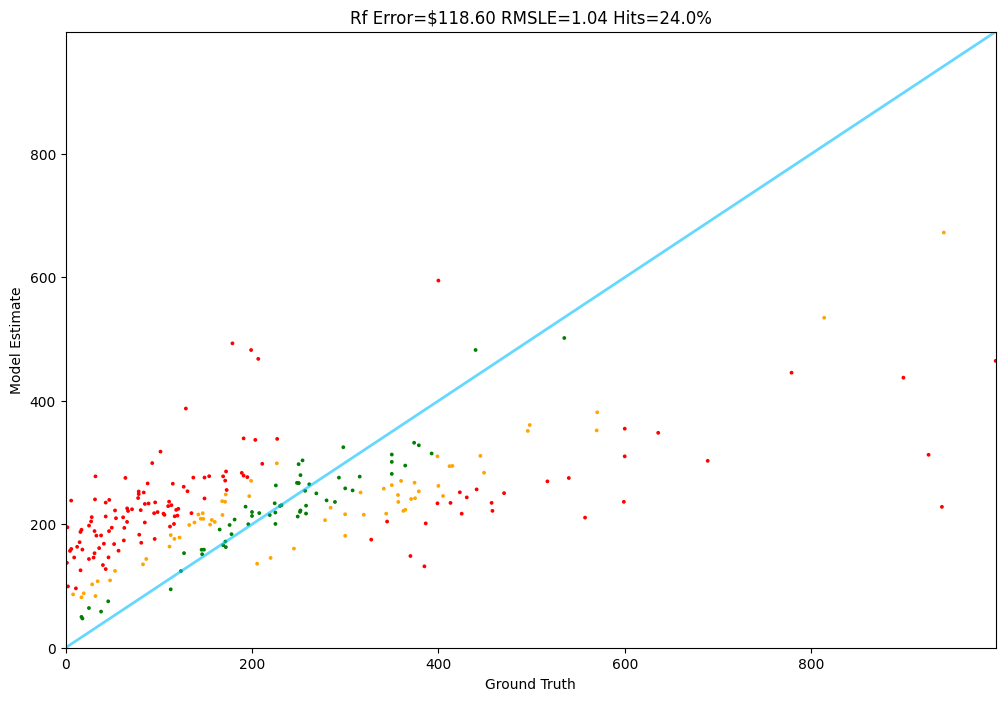

In [ ]:
# Use Tester to score RF predictions over the test set
Tester.test(rf, test)

In [ ]:
# Try pricing a product string with all three pricers to compare outputs
product = "Quadcast HyperX condenser mic for high quality audio for podcasting"

In [48]:
print(specialist.price(product))
print(frontier.price(product))
print(random_forest.price(product))

110.0
139.99
244.3197


In [ ]:
# Run the three pricers on a slice of the test set (IDs 1000:1250) and store results to build ensemble training data
specialists = []
frontiers = []
random_forests = []
prices = []
for item in tqdm(test[1000:1250]):
    text = description(item)
    specialists.append(specialist.price(text))
    frontiers.append(frontier.price(text))
    random_forests.append(random_forest.price(text))
    prices.append(item.price)

100%|██████████| 250/250 [14:29<00:00,  3.48s/it]


In [ ]:
# Create a DataFrame X with predictions from the three pricers + min/max of their outputs, the target y is true prices
mins = [min(s,f,r) for s,f,r in zip(specialists, frontiers, random_forests)]
maxes = [max(s,f,r) for s,f,r in zip(specialists, frontiers, random_forests)]

X = pd.DataFrame({
    'Specialist': specialists,
    'Frontier': frontiers,
    'RandomForest': random_forests,
    'Min': mins,
    'Max': maxes,
})

# Convert y to a Series
y = pd.Series(prices)

In [ ]:
# Fit a simple linear regression that learns weights for each pricer, this is the ensemble trainer
np.random.seed(42)

lr = LinearRegression()
lr.fit(X, y)

feature_columns = X.columns.tolist()

for feature, coef in zip(feature_columns, lr.coef_):
    print(f"{feature}: {coef:.2f}")
print(f"Intercept={lr.intercept_:.2f}")

Specialist: 0.34
Frontier: 0.73
RandomForest: 0.31
Min: 0.04
Max: -0.35
Intercept=48.88


In [ ]:
# Save trained linear reg to disk
joblib.dump(lr, 'ensemble_model.pkl')

['ensemble_model.pkl']

In [ ]:
# Import and create an EnsembleAgent that wraps ensemble logic and uses the Chroma collection
from agents.ensemble_agent import EnsembleAgent
ensemble = EnsembleAgent(collection)

In [ ]:
# Run the ensemble pricer on the product string to see its combined output
ensemble.price(product)

182.10892813758298

In [ ]:
# Create a safe wrapper that ensures price is non-negative and test it using Tester on full test set
def ensemble_pricer(item):
    return max(0,ensemble.price(description(item)))

1: Guess: $326.27 Truth: $374.41 Error: $48.14 SLE: 0.02 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $104.41 Truth: $225.11 Error: $120.70 SLE: 0.58 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $81.65 Truth: $61.68 Error: $19.97 SLE: 0.08 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $531.03 Truth: $599.99 Error: $68.96 SLE: 0.01 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $63.70 Truth: $16.99 Error: $46.71 SLE: 1.64 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $61.71 Truth: $31.99 Error: $29.72 SLE: 0.41 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $130.69 Truth: $101.79 Error: $28.90 SLE: 0.06 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $295.56 Truth: $289.00 Error: $6.56 SLE: 0.00 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $516.43 Truth: $635.86 Error: $119.43 SLE: 0.04 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $97.96 Truth: $65.99 Error: $31.97 SLE: 0.15 I

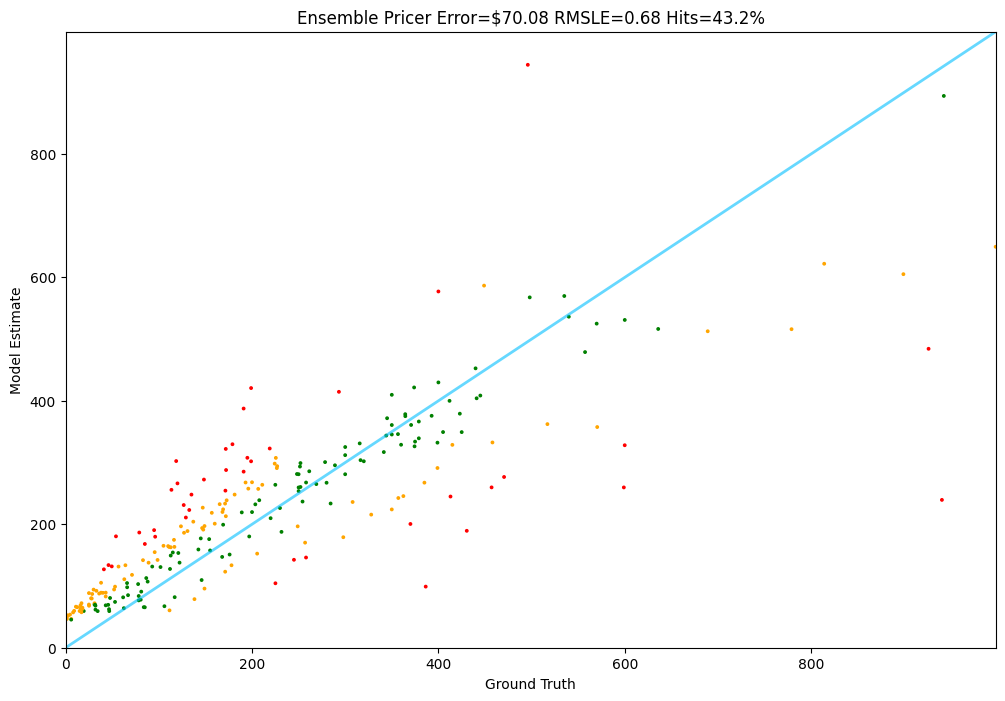

In [57]:
Tester.test(ensemble_pricer, test)